## Image Adjustment
****

### Brightness and Contrast Adjustment
1. Brightness: This is the adjustment of the lightness or darkness of an image. An image's brightness can be increased by adding a constant to every pixel value of the image.

2. Contrast: This represents the difference between the darkest and lightest regions of an image. The contrast can be increased by multiplying every pixel value of the image by a constant.

In [ ]:
import numpy as np

def save_array_as_image(array, image_path):
    """Save a numpy array as an image"""
    from PIL import Image
    img = Image.fromarray(np.uint8(array))
    img.save(image_path)

def adjust_brightness_contrast(image_array, alpha=1.0, beta=0):
    """Adjust contrast and brightness of the image array."""
    
    # Adjust contrast by multiplying each pixel value
    image_array = alpha * image_array
    
    # Adjust brightness by adding to every value.
    image_array += beta

    # Clip values to be in the range [0, 255]
    image_array = np.clip(image_array, 0, 255)
    
    return image_array

input_path = "path_to_input_image.jpg"
output_path = "path_to_output_image.jpg"
image_data = load_image_as_array(input_path)

adjusted_image_data = adjust_brightness_contrast(image_data, 1.5, 50)  # 1.5 is alpha (contrast), 50 is beta (brightness)

save_array_as_image(adjusted_image_data, output_path)


In [1]:
import cv2
import numpy as np

window_name = "Interactive Curve with OpenCV"
canvas_size = 256
points = [(0, canvas_size), (canvas_size, 0)]

def draw_canvas(points):
    canvas = np.ones((canvas_size, canvas_size, 3), dtype=np.uint8) * 255
    for i in range(1, len(points)):
        cv2.line(canvas, points[i-1], points[i], (255, 0, 0), 2)
    return canvas

def apply_curve(image, points):
    lut = create_lut(points)
    
    # Convert the tuple to a list for modification
    img_data = list(cv2.split(image))
    
    for i in range(3):  # B, G, R channels
        img_data[i] = cv2.LUT(img_data[i], lut)
    
    # Merge the channels back and return the image
    return cv2.merge(img_data)


def create_lut(points):
    lut = np.zeros(256, dtype=np.uint8)
    for i in range(1, len(points)):
        x0, y0 = points[i - 1]
        x1, y1 = points[i]
        
        if x1 >= len(lut):  # Make sure x1 doesn't exceed the LUT boundary
            x1 = len(lut) - 1

        expected_size = x1 - x0 + 1
        values = np.linspace(y0, y1, num=expected_size, dtype=np.uint8, endpoint=True)
        
        # Debugging information
        print(f"Points: {(x0, y0)} to {(x1, y1)}")
        print(f"Expected size: {expected_size}, Linspace size: {len(values)}")
        
        # If the sizes do not match, adjust the values array
        while len(values) < expected_size:
            values = np.append(values, values[-1])
        while len(values) > expected_size:
            values = values[:-1]

        lut[x0:x1+1] = values
        
    return lut.astype(np.uint8)



def on_mouse_click(event, x, y, flags, param):
    global points, original_image

    if event == cv2.EVENT_LBUTTONDOWN:
        points.append((x, y))
        points.sort(key=lambda pt: pt[0])
        
        curve_canvas = draw_canvas(points)
        cv2.imshow(window_name, curve_canvas)
        
        adjusted_image = apply_curve(original_image, points)
        cv2.imshow("Adjusted Image", adjusted_image)

original_image = cv2.imread("Graphics/face.png")
cv2.namedWindow(window_name)
cv2.setMouseCallback(window_name, on_mouse_click)

curve_canvas = draw_canvas(points)
cv2.imshow(window_name, curve_canvas)
cv2.imshow("Original Image", original_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


Points: (0, 256) to (171, 155)
Expected size: 172, Linspace size: 172
Points: (171, 155) to (255, 0)
Expected size: 85, Linspace size: 85
Points: (0, 256) to (171, 155)
Expected size: 172, Linspace size: 172
Points: (171, 155) to (196, 57)
Expected size: 26, Linspace size: 26
Points: (196, 57) to (255, 0)
Expected size: 60, Linspace size: 60
Points: (0, 256) to (97, 226)
Expected size: 98, Linspace size: 98
Points: (97, 226) to (171, 155)
Expected size: 75, Linspace size: 75
Points: (171, 155) to (196, 57)
Expected size: 26, Linspace size: 26
Points: (196, 57) to (255, 0)
Expected size: 60, Linspace size: 60
Points: (0, 256) to (74, 116)
Expected size: 75, Linspace size: 75
Points: (74, 116) to (97, 226)
Expected size: 24, Linspace size: 24
Points: (97, 226) to (171, 155)
Expected size: 75, Linspace size: 75
Points: (171, 155) to (196, 57)
Expected size: 26, Linspace size: 26
Points: (196, 57) to (255, 0)
Expected size: 60, Linspace size: 60
Points: (0, 256) to (74, 116)
Expected size:

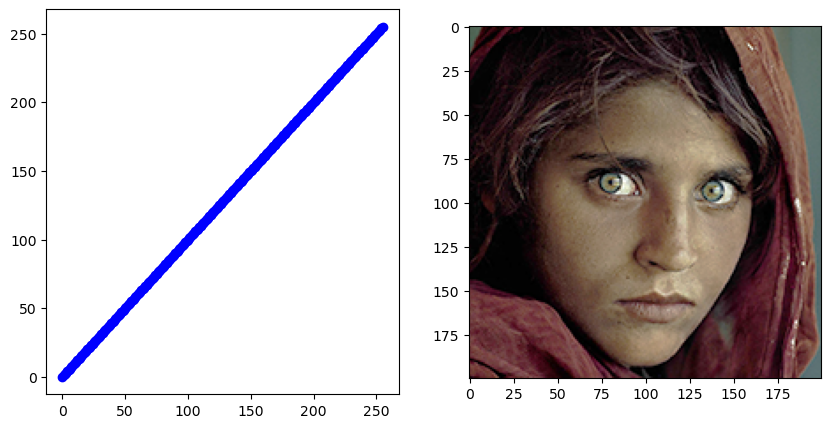

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

class InteractiveCurve:
    def __init__(self, image_path):
        self.image = cv2.imread(image_path)
        self.image = cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB)
        self.lut = np.arange(256)

        self.fig, self.axs = plt.subplots(1, 2, figsize=(10, 5))
        self.line, = self.axs[0].plot(self.lut, self.lut, '-o', color='blue')
        self.axs[1].imshow(self.image)

        self.cid = self.line.figure.canvas.mpl_connect('button_press_event', self)

    def __call__(self, event):
        if event.inaxes != self.line.axes:
            return

        # Find the closest point
        idx = np.argmin(np.abs(self.line.get_ydata() - event.ydata))
        self.lut[idx] = event.ydata

        # Update LUT curve
        self.line.set_ydata(self.lut)
        self.line.figure.canvas.draw()

        # Apply LUT to the image
        adjusted_image = cv2.LUT(self.image, self.lut.astype(np.uint8))
        self.axs[1].imshow(adjusted_image)
        self.axs[1].figure.canvas.draw()

if __name__ == "__main__":
    curve_editor = InteractiveCurve("Graphics/face.png")
    plt.show()
